In [1]:
import os
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import sklearn, skimage, scipy
from collections import defaultdict
import glob

In [2]:
cd ..

e:\river_seg\airc


In [3]:
import rootutils
rootutils.set_root(os.getcwd(), pythonpath=True)
from src.zero_shot.utils import prune

In [ ]:
from scipy.ndimage import distance_transform_edt
from skimage.morphology import skeletonize
from skimage.measure import label

def thickness_per_component(mask, spacing=(1.0, 1.0), connectivity=1):
    """
    Compute thickness for all disjoint components in a binary mask.

    Parameters
    ----------
    mask : np.ndarray, bool or {0,1}, shape (H, W)
        Binary image. Non-zero = foreground.
    spacing : tuple(float, float)
        Pixel spacing (dy, dx). Use real units if available, e.g. (mm_per_pixel, mm_per_pixel).
    connectivity : {1, 2}
        4-connectivity (1) or 8-connectivity (2) for labeling.

    Returns
    -------
    thickness_map : np.ndarray, float
        Local thickness values on skeleton pixels (0 elsewhere), same shape as mask.
    component_stats : dict
        Mapping: label_id -> dict of stats (mean, median, max, min, area, n_skel).
    labels : np.ndarray, int
        Labeled image of connected components.
    """
    mask = mask.astype(bool)

    # Label disjoint components
    labels = label(mask, connectivity=connectivity)
    num_labels = labels.max()

    if num_labels == 0:
        return np.zeros_like(mask, dtype=float), {}, labels

    # Distance transform on entire mask (reused for all components)
    dist = distance_transform_edt(mask, sampling=spacing)

    # Skeleton on entire mask
    skel = skeletonize(mask)

    thickness_map = np.zeros_like(dist, dtype=float)
    component_stats = {}

    for lab in range(1, num_labels + 1):
        comp_mask = labels == lab
        comp_skel = skel & comp_mask

        # Local thickness = 2 * distance to boundary on skeleton pixels
        tvals = 2.0 * dist[comp_skel]

        # Fill global thickness map
        thickness_map[comp_skel] = tvals

        if tvals.size > 0:
            stats = {
                "mean": float(np.mean(tvals)),
                "median": float(np.median(tvals)),
                "max": float(np.max(tvals)),
                "min": float(np.min(tvals)),
                "area_pixels": int(comp_mask.sum()),
                "n_skeleton_pixels": int(comp_skel.sum()),
            }
        else:
            # Very small object, no skeleton after thinning
            stats = {
                "mean": 0.0,
                "median": 0.0,
                "max": 0.0,
                "min": 0.0,
                "area_pixels": int(comp_mask.sum()),
                "n_skeleton_pixels": 0,
            }

        component_stats[lab] = stats

    return thickness_map, component_stats, labels


In [4]:
def predict(quantized, beta, gamma=1.5): 
        quantized = (quantized.astype(float) / 255) ** gamma
        quantized = (quantized  * 255).astype(np.uint8)
        beta_mask = (quantized >= int(beta * 255)).astype(np.uint8)
        b1 = cv2.adaptiveThreshold(quantized, 
                                            1, 
                                            cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                            cv2.THRESH_BINARY, 
                                            51, 
                                            -10)
        b2 = cv2.adaptiveThreshold(quantized, 
                                            1, 
                                            cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                            cv2.THRESH_BINARY, 
                                            71, 
                                            -15)
        mask = np.maximum(beta_mask, np.maximum(b1, b2))
        mask = prune(mask, min_size=500)
        return mask

In [5]:
root_dir =  Path(r"E:/river_seg/airc/paper_outputs/prob_2025-12-08_02-10-26")
# root_dir =  Path(r"E:/river_seg/airc/paper_outputs/prob_2025-12-07_19-35-41")
# root_dir = Path(r"E:/river_seg/airc/paper_outputs/prob_2025-12-07_23-28-39")

In [55]:
inspect = np.array([[1877, 834], [2100, 1650], [507, 3659], [1120, 4982], [2766, 5781]])[:, ::-1]

In [56]:
def load_metrics(path):
    metrics = {}
    with open(path, 'r') as f:
        for line in f:
            line = line.strip()
            # skip empty lines and header line
            if not line or line.lower().startswith("metric"):
                continue

            parts = line.split()
            # first token: metric key (e.g., "dice", "jaccard", "mean_surface_distance")
            # last token: numeric score
            name = parts[0]
            value = float(parts[-1])
            metrics[name] = value
    return metrics

# example usage
# e.g. metrics["dice"] -> 0.816484


In [57]:
roc_yrs = defaultdict(list)
roc_samples = defaultdict(list)
metrics = dict()


In [58]:
years  = os.listdir(root_dir)
for year in years: 
    folder = root_dir / year
    metrics[year] = defaultdict(list)
    
    for iteration in os.listdir(folder):
        path = folder / iteration
        metric_path = glob.glob(str(path / "macro_*.txt"))[0]
        metric = load_metrics(metric_path)
        # print(metric)
        for key in metric.keys():
            metrics[year][key].append(metric[key])
        macro = np.load(path / "macro_roc_curve.npy")
        micro = np.load(path / "micro_roc_curves.npy")
        roc_yrs[year].append(macro)
        roc_samples[year].append(micro)
    metrics[year]['best'] = np.argmax(metrics[year]['dice'])


In [ ]:
patches = [[] for i in range(inspect.shape[0])]
images = [[] for i in range(inspect.shape[0])]
for year in years:
    folder = root_dir / year
    path = folder / f"{metrics[year]['best']:02d}/ensembled_output/mask.jpg"
    image = cv2.imread(f"E:/river_seg/airc/data/v2/{year}.png", cv2.IMREAD_UNCHANGED)
    
    
    mask = cv2.imread(str(path))[..., -1] 
    for index, pt in enumerate(inspect): 
        src, dst = pt - 64, pt + 64
        # patches[index].append(predict(mask[src[0]:dst[0], src[1]:dst[1]].copy(), 0.4, gamma=1.5))
        patches[index].append(cv2.erode(scipy.ndimage.binary_fill_holes(cv2.dilate(mask[src[0]:dst[0], src[1]:dst[1]].copy(),
                                                                        kernel=np.ones([3, 3]), 
                                                                        iterations=2) > 120).astype(np.uint8),
                                        kernel=np.ones([3, 3]), 
                                        iterations=2)
                            )
        images[index].append(image[src[0]:dst[0], src[1]:dst[1]].copy())
        

In [60]:
patches = [np.stack(patch, axis=-1) for patch in patches]

In [61]:
patches[0].shape

(128, 128, 9)

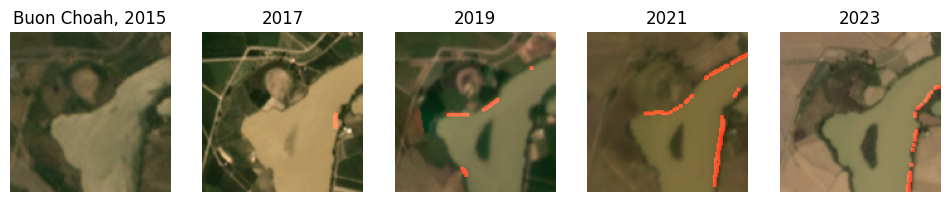

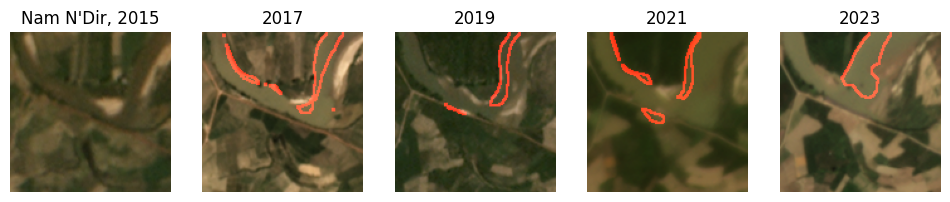

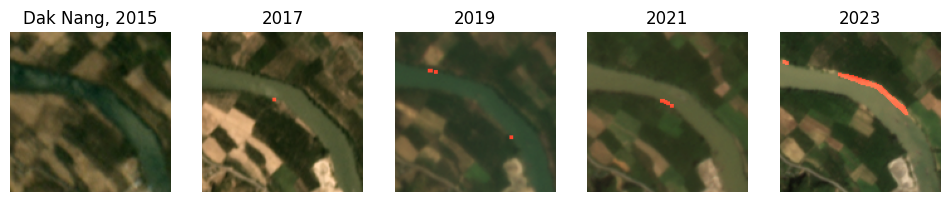

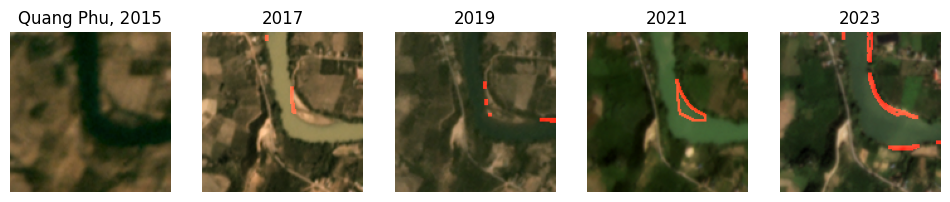

In [62]:
time = 9
start = 0
indexes = [1, 2, 3, 4]
cmap = mpl.colormaps['viridis']
years  = os.listdir(root_dir)
diff = [[] for i in indexes]
names = [".","Buon Choah", "Nam N'Dir", "Dak Nang", "Quang Phu"]
for ax_row, index in enumerate(indexes):
    f, axes = plt.subplots(1, time // 2 + 1, figsize=(len(indexes) * 3, (time // 2 + 1) * 4))
    for ax_col, i in enumerate(range(start, start + time, 2)):
        # logit_im = cmap(patches[index][..., i]) * 255
        # logit_im = logit_im.astype(np.uint8)[..., :3]
        # print(logit_im.shape)
        plot_im = images[index][i][..., ::-1].copy()
        if ax_col > 0:
            diff[ax_row].append(patches[index][..., i] * ( 1 - patches[index][..., :i - 1].max(axis=-1)))
            plot_pos = scipy.ndimage.morphological_gradient(diff[ax_row][-1], size=3)
            plot_im[..., 0][plot_pos > 0] = 255
        # di = [ax_index // 3, ax_index]
        axes[ax_col].imshow(plot_im)
        axes[ax_col].axis('off')
        if ax_col > 0:
            axes[ax_col].set_title(years[i])
        else:
            axes[ax_col].set_title(f"{names[index]}, {years[i]}")
    # f.text(0.5, 0.02, 'Row 1 Title', ha='center', va='center', fontsize=14, fontweight='bold', rotation=90)
# plt.tight_layout()
    plt.axis('off')
    plt.savefig(f"E:/river_seg/airc/data/erosion_{names[index]}.jpg", bbox_inches='tight', pad_inches=0.1)
    # plt.close()
    plt.pause(1.)

In [63]:
results = dict()
for i, reg in enumerate(diff):
    results[names[indexes[i]]] = defaultdict(list)
    for j, reg_it in enumerate(reg):
        _, stats, labels = thickness_per_component(reg_it, spacing=(4.77, 4.77), connectivity=2)
        area = sum([stats[key]['area_pixels'] for key in stats.keys()])
        dist = max([stats[key]['mean'] for key in stats.keys()])
        results[names[indexes[i]]]['area'].append(area)
        results[names[indexes[i]]]['dist'].append(dist)

In [ ]:
for year in years:
    print(f"{year} {metrics[year]['best']}:{metrics[year]['dice'][metrics[year]['best']]}")

2015 0:0.816484
2016 2:0.858684
2017 0:0.869389
2018 2:0.823927
2019 1:0.870091
2020 4:0.921587
2021 3:0.847869
2022 2:0.898644
2023 3:0.899863


In [ ]:
from matplotlib.collections import LineCollection

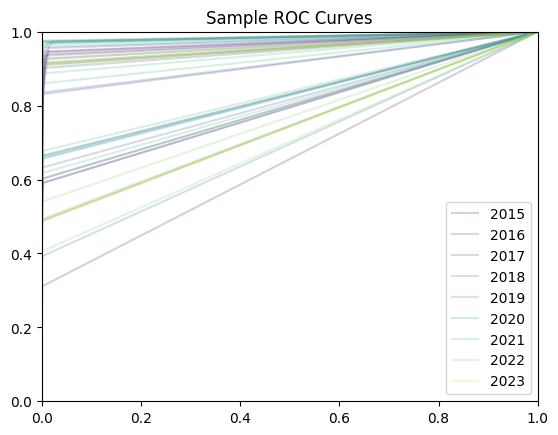

In [ ]:
cmap = mpl.colormaps['viridis']
micro_curves = []
f, ax = plt.subplots(1, 1)
for index, key in enumerate(roc_yrs.keys()):
    ax.add_collection(LineCollection(roc_yrs[key], color=cmap(float(index / len(roc_yrs)), alpha=0.2), label=key))
    # print(np.concatenate(roc_samples[key], axis=0).shape)
    micro_curves.append(np.concatenate(roc_samples[key], axis=0))
    # plt.plot(curve[:, 0], curve[:, 1], c = [0, 0, 1, 0.5])
ax.legend(loc="lower right")
ax.set_xlim([0, 1]) # have to set manually
ax.set_ylim([0, 1])
plt.title("Sample ROC Curves")
plt.savefig("E:/river_seg/airc/data/macro_curves.jpg")
plt.show()

In [ ]:
mic_cr = np.concatenate(micro_curves, axis=0)

In [ ]:
mic_cr.shape

(3772, 40, 2)

In [ ]:
plt.clf()

<Figure size 640x480 with 0 Axes>

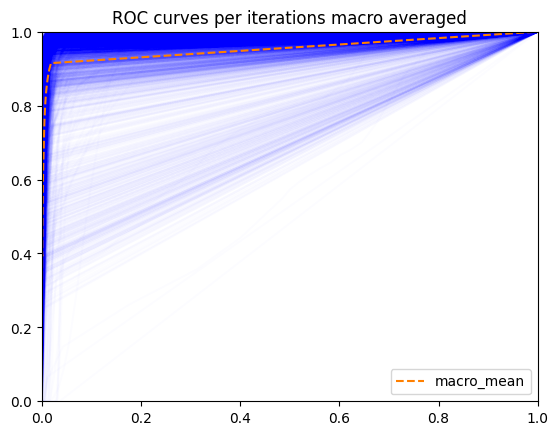

In [ ]:
f, ax = plt.subplots(1, 1)
ax.add_collection(LineCollection(mic_cr, color=[0, 0, 1, 0.01]))
mean_cr = mic_cr.mean(axis=0)
ax.plot(mean_cr[:, 0], mean_cr[:, 1], linestyle='dashed', c=[1, 0.5, 0, 1], label="macro_mean")
ax.legend()
ax.set_xlim([0, 1]) # have to set manually
ax.set_ylim([0, 1])
ax.legend(loc=4)
plt.title("ROC curves per iterations macro averaged")
plt.savefig("E:/river_seg/airc/data/sample_curves.jpg")
plt.show()
